# Markov Model applied to Lac Operon simulated data

Model used is provided in pyro examples https://pyro.ai/examples/dmm.html

The general idea here is that we have observations of variables at certain steps (say every 100 steps of the stochastic sim). Can we train a model for this sequential data, with a latent variable to describe the interaction between variables. Could this account for issues like in Lac Operon like cycles?

![alt text](../images/model_example.png "Title")

$$P(x_{123}, z_{123}) = p(x_1|z_1)p(x_2|z_2)p(x_3|z_3)p(z_3|z_2)P(z_2|z_1)p(z_1)$$

### Packages

In [3]:
import time, random
import pickle5 as pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import torch
# from torch import nn, tensor
# import pyro
# from pyro.optim import ClippedAdam
# from pyro.infer import SVI, Trace_ELBO
# import pyro.distributions as dist
# import pyro.poutine as poutine
# from pyro.contrib.examples import polyphonic_data_loader as poly

%matplotlib inline

### Load data

In [4]:
with open(r"../data/sim_data.pickle", "rb") as input_file:
     sim_data = pickle.load(input_file)

In [5]:
sim_data[0].head()

,rna_M,monomer_betaGal,protein_betaGal,Lactose_external,Lactose_internal,Glucose_external,Glucose_internal,protein_Lactose_Permease,dna_Lac_Operon,Biomass,Lactose_consumed,time
0,0.0,0.0,0.0,120440000.0,0.0,60220000.0,0.0,0.0,2.0,1000.0,0.0,0.0
1,0.0,0.0,0.0,120440000.0,0.0,59918175.0,301825.0,0.0,2.0,1000.0,0.0,1.0
2,0.0,0.0,0.0,120440000.0,0.0,59617267.0,602733.0,0.0,2.0,1000.0,0.0,2.0
3,0.0,0.0,0.0,120440000.0,0.0,59315263.0,904737.0,0.0,2.0,1000.0,0.0,3.0
4,0.0,0.0,0.0,120440000.0,0.0,59014271.0,1205729.0,0.0,2.0,1000.0,0.0,4.0


In [5]:
len(sim_data[0].columns)

12

### Build Model

Transition from latent Z to X

In [30]:
class Emitter(nn.Module):
    """
    Parameterizes the linear observation likelihood p(x_t | z_t)
    
    Devon: bernoulli is wrong for this model I think
            Added linear observation. I think theoretically we might be able to use a better output function
    
    """
    def __init__(self, input_dim, z_dim, emission_dim):
        super().__init__()
        # initialize the three linear transformations used in the neural network
        self.lin_z_to_hidden = nn.Linear(z_dim, emission_dim)
        self.lin_hidden_to_hidden = nn.Linear(emission_dim, emission_dim)
        self.lin_hidden_to_input = nn.Linear(emission_dim, input_dim)
        # initialize the two non-linearities used in the neural network
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid() ## We want the resulting value to be continuous
        self.linear = nn.Linear(input_dim, input_dim) ## Assuming internal glucose is output
        self.softplus = nn.Softplus()

    def forward(self, z_t):
        """
        Given the latent z at a particular time step t we return the vector of
        probabilities `ps` that parameterizes the bernoulli distribution p(x_t|z_t)
        """
#         h1 = self.relu(self.lin_z_to_hidden(z_t))
#         h2 = self.relu(self.lin_hidden_to_hidden(h1))
#         #ps = self.linear(self.lin_hidden_to_input(h2))
#         ps = self.sigmoid(self.lin_hidden_to_input(h2))

        # compute the gating function
        _gate = self.relu(self.lin_z_to_hidden(z_t))
        gate = self.sigmoid(self.lin_hidden_to_input(_gate))
        # compute the 'proposed mean'
        _proposed_mean = self.relu(self.lin_z_to_hidden(z_t))
        proposed_mean = self.lin_hidden_to_input(_proposed_mean)
        # assemble the actual mean used to sample z_t, which mixes
        # a linear transformation of z_{t-1} with the proposed mean
        # modulated by the gating function
        loc = (1 - gate) * self.lin_hidden_to_input(z_t) + gate * proposed_mean
        # compute the scale used to sample z_t, using the proposed
        # mean from above as input. the softplus ensures that scale is positive
        scale = self.softplus(self.linear(self.relu(proposed_mean)))
        
        return loc, scale

Transition between latent Zs

In [31]:
class GatedTransition(nn.Module):
    """
    Parameterizes the gaussian latent transition probability p(z_t | z_{t-1})
    See section 5 in the reference for comparison.
    """
    def __init__(self, z_dim, transition_dim):
        super().__init__()
        # initialize the six linear transformations used in the neural network
        self.lin_gate_z_to_hidden = nn.Linear(z_dim, transition_dim)
        self.lin_gate_hidden_to_z = nn.Linear(transition_dim, z_dim)
        self.lin_proposed_mean_z_to_hidden = nn.Linear(z_dim, transition_dim)
        self.lin_proposed_mean_hidden_to_z = nn.Linear(transition_dim, z_dim)
        self.lin_sig = nn.Linear(z_dim, z_dim)
        self.lin_z_to_loc = nn.Linear(z_dim, z_dim)
        # modify the default initialization of lin_z_to_loc
        # so that it's starts out as the identity function
        self.lin_z_to_loc.weight.data = torch.eye(z_dim)
        self.lin_z_to_loc.bias.data = torch.zeros(z_dim)
        # initialize the three non-linearities used in the neural network
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.softplus = nn.Softplus()

    def forward(self, z_t_1):
        """
        Given the latent z_{t-1} corresponding to the time step t-1
        we return the mean and scale vectors that parameterize the
        (diagonal) gaussian distribution p(z_t | z_{t-1})
        """
        # compute the gating function
        _gate = self.relu(self.lin_gate_z_to_hidden(z_t_1))
        gate = self.sigmoid(self.lin_gate_hidden_to_z(_gate))
        # compute the 'proposed mean'
        _proposed_mean = self.relu(self.lin_proposed_mean_z_to_hidden(z_t_1))
        proposed_mean = self.lin_proposed_mean_hidden_to_z(_proposed_mean)
        # assemble the actual mean used to sample z_t, which mixes
        # a linear transformation of z_{t-1} with the proposed mean
        # modulated by the gating function
        loc = (1 - gate) * self.lin_z_to_loc(z_t_1) + gate * proposed_mean
        # compute the scale used to sample z_t, using the proposed
        # mean from above as input. the softplus ensures that scale is positive
        scale = self.softplus(self.lin_sig(self.relu(proposed_mean)))
        # return loc, scale which can be fed into Normal
        return loc, scale

### Build Guide

In [32]:
class Combiner(nn.Module):
    """
    Parameterizes q(z_t | z_{t-1}, x_{t:T}), which is the basic building block
    of the guide (i.e. the variational distribution). The dependence on x_{t:T} is
    through the hidden state of the RNN (see the pytorch module `rnn` below)
    """
    def __init__(self, z_dim, rnn_dim):
        super().__init__()
        # initialize the three linear transformations used in the neural network
        self.lin_z_to_hidden = nn.Linear(z_dim, rnn_dim)
        self.lin_hidden_to_loc = nn.Linear(rnn_dim, z_dim)
        self.lin_hidden_to_scale = nn.Linear(rnn_dim, z_dim)
        # initialize the two non-linearities used in the neural network
        self.tanh = nn.Tanh()
        self.softplus = nn.Softplus()
        #self.softplus = nn.ReLU()

    def forward(self, z_t_1, h_rnn):
        """
        Given the latent z at at a particular time step t-1 as well as the hidden
        state of the RNN h(x_{t:T}) we return the mean and scale vectors that
        parameterize the (diagonal) gaussian distribution q(z_t | z_{t-1}, x_{t:T})
        """
        # combine the rnn hidden state with a transformed version of z_t_1
        h_combined = 0.5 * (self.tanh(self.lin_z_to_hidden(z_t_1)) + h_rnn)
        # use the combined hidden state to compute the mean used to sample z_t
        loc = self.lin_hidden_to_loc(h_combined)
        # use the combined hidden state to compute the scale used to sample z_t
        scale = self.softplus(self.lin_hidden_to_scale(h_combined))
        #scale = self.softplus(h_combined)

        # return loc, scale which can be fed into Normal
        return loc, scale

### Full Model

In [33]:
class DMM(nn.Module):
    """
    This PyTorch Module encapsulates the model as well as the
    variational distribution (the guide) for the Deep Markov Model
    """
    def __init__(self, input_dim=12, z_dim=25, emission_dim=25,
                 transition_dim=50, rnn_dim=150, rnn_dropout_rate=0.0,
                 num_iafs=0, iaf_dim=50, use_cuda=True):
        super().__init__()
        # instantiate pytorch modules used in the model and guide below
        self.emitter = Emitter(input_dim, z_dim, emission_dim)
        self.trans = GatedTransition(z_dim, transition_dim)
        self.combiner = Combiner(z_dim, rnn_dim)
        self.rnn = nn.RNN(input_size=input_dim, hidden_size=rnn_dim,
                          nonlinearity='relu', batch_first=True,
                          bidirectional=False, num_layers=1, dropout=rnn_dropout_rate)

        # define a (trainable) parameters z_0 and z_q_0 that help define
        # the probability distributions p(z_1) and q(z_1)
        # (since for t = 1 there are no previous latents to condition on)
        self.z_0 = nn.Parameter(torch.zeros(z_dim))
        self.z_q_0 = nn.Parameter(torch.zeros(z_dim))
        # define a (trainable) parameter for the initial hidden state of the rnn
        self.h_0 = nn.Parameter(torch.zeros(1, 1, rnn_dim))

        self.use_cuda = use_cuda
        # if on gpu cuda-ize all pytorch (sub)modules
        if use_cuda:
            self.cuda()

    # the model p(x_{1:T} | z_{1:T}) p(z_{1:T})
    def model(self, mini_batch, mini_batch_reversed, mini_batch_mask,
              mini_batch_seq_lengths, annealing_factor=1.0):

        # this is the number of time steps we need to process in the mini-batch
        T_max = mini_batch.size(1)

        # register all PyTorch (sub)modules with pyro
        # this needs to happen in both the model and guide
        pyro.module("dmm", self)

        # set z_prev = z_0 to setup the recursive conditioning in p(z_t | z_{t-1})
        z_prev = self.z_0.expand(mini_batch.size(0), self.z_0.size(0))

        # we enclose all the sample statements in the model in a plate.
        # this marks that each datapoint is conditionally independent of the others
        with pyro.plate("z_minibatch", len(mini_batch)):
            # sample the latents z and observed x's one time step at a time
            for t in range(1, T_max + 1):
                # the next chunk of code samples z_t ~ p(z_t | z_{t-1})
                # note that (both here and elsewhere) we use poutine.scale to take care
                # of KL annealing. we use the mask() method to deal with raggedness
                # in the observed data (i.e. different sequences in the mini-batch
                # have different lengths)

                # first compute the parameters of the diagonal gaussian
                # distribution p(z_t | z_{t-1})
                z_loc, z_scale = self.trans(z_prev)

                # then sample z_t according to dist.Normal(z_loc, z_scale).
                # note that we use the reshape method so that the univariate
                # Normal distribution is treated as a multivariate Normal
                # distribution with a diagonal covariance.
                with poutine.scale(None, annealing_factor):
                    z_t = pyro.sample("z_%d" % t,
                                      dist.Normal(z_loc, z_scale)
                                          .mask(mini_batch_mask[:, t - 1:t])
                                          .to_event(1))

                # compute the probabilities that parameterize the bernoulli likelihood
                emission_probs_mean, emission_probs_scale = self.emitter(z_t)
                # the next statement instructs pyro to observe x_t according to the
                # bernoulli distribution p(x_t|z_t)
                pyro.sample("obs_x_%d" % t,
                            #dist.Bernoulli(emission_probs_t)
                            dist.Normal(emission_probs_mean, emission_probs_scale)
                                .mask(mini_batch_mask[:, t - 1:t])
                                .to_event(1),
                            obs=mini_batch[:, t - 1, :])
                # the latent sampled at this time step will be conditioned upon
                # in the next time step so keep track of it
                z_prev = z_t

    # the guide q(z_{1:T} | x_{1:T}) (i.e. the variational distribution)
    def guide(self, mini_batch, mini_batch_reversed, mini_batch_mask,
          mini_batch_seq_lengths, annealing_factor=1.0):

        # this is the number of time steps we need to process in the mini-batch
        T_max = mini_batch.size(1)
        # register all PyTorch (sub)modules with pyro
        pyro.module("dmm", self)

        # if on gpu we need the fully broadcast view of the rnn initial state
        # to be in contiguous gpu memory
        h_0_contig = self.h_0.expand(1, mini_batch.size(0),
                                     self.rnn.hidden_size).contiguous()
        # push the observed x's through the rnn;
        # rnn_output contains the hidden state at each time step
        rnn_output, _ = self.rnn(mini_batch_reversed, h_0_contig)
        # reverse the time-ordering in the hidden state and un-pack it
        rnn_output = pad_and_reverse(rnn_output, mini_batch_seq_lengths)
        # set z_prev = z_q_0 to setup the recursive conditioning in q(z_t |...)
        z_prev = self.z_q_0.expand(mini_batch.size(0), self.z_q_0.size(0))

        # we enclose all the sample statements in the guide in a plate.
        # this marks that each datapoint is conditionally independent of the others.
        with pyro.plate("z_minibatch", len(mini_batch)):
            # sample the latents z one time step at a time
            for t in range(1, T_max + 1):
                # the next two lines assemble the distribution q(z_t | z_{t-1}, x_{t:T})
                z_loc, z_scale = self.combiner(z_prev, rnn_output[:, t - 1, :])
                
                z_dist = dist.Normal(tensor(z_loc), tensor(z_scale))

                # sample z_t from the distribution z_dist
                with pyro.poutine.scale(None, annealing_factor):
                    z_t = pyro.sample("z_%d" % t,
                                      z_dist.mask(mini_batch_mask[:, t - 1:t])
                                            .to_event(1))
                # the latent sampled at this time step will be conditioned
                # upon in the next time step so keep track of it
                z_prev = z_t

### pyro.contrib.examples.polyphonic_data_loader Functions

This pyro function is not working in current version of pyro. Maybe would work if directly installed dev branch from github. Just load the functions here instead.

In [45]:
# this function takes the hidden state as output by the PyTorch rnn and
# unpacks it it; it also reverses each sequence temporally
def pad_and_reverse(rnn_output, seq_lengths):
    rnn_output, _ = nn.utils.rnn.pad_packed_sequence(rnn_output, batch_first=True)
    reversed_output = reverse_sequences(rnn_output, seq_lengths)
    return reversed_output
def reverse_sequences(mini_batch, seq_lengths):
    reversed_mini_batch = torch.zeros_like(mini_batch)
    for b in range(mini_batch.size(0)):
        T = seq_lengths[b]
        time_slice = torch.arange(T - 1, -1, -1, device=mini_batch.device)
        reversed_sequence = torch.index_select(mini_batch[b, :, :], 0, time_slice)
        reversed_mini_batch[b, 0:T, :] = reversed_sequence
    return reversed_mini_batch
# this function returns a 0/1 mask that can be used to mask out a mini-batch
# composed of sequences of length `seq_lengths`
def get_mini_batch_mask(mini_batch, seq_lengths):
    mask = torch.zeros(mini_batch.shape[0:2])
    for b in range(mini_batch.shape[0]):
        mask[b, 0 : seq_lengths[b]] = torch.ones(seq_lengths[b])
    return mask
# this function prepares a mini-batch for training or evaluation.
# it returns a mini-batch in forward temporal order (`mini_batch`) as
# well as a mini-batch in reverse temporal order (`mini_batch_reversed`).
# it also deals with the fact that packed sequences (which are what what we
# feed to the PyTorch rnn) need to be sorted by sequence length.
def get_mini_batch(mini_batch_indices, sequences, seq_lengths, cuda=True):
    # get the sequence lengths of the mini-batch
    seq_lengths = seq_lengths[mini_batch_indices]
    # sort the sequence lengths
    _, sorted_seq_length_indices = torch.sort(seq_lengths)
    sorted_seq_length_indices = sorted_seq_length_indices.flip(0)
    sorted_seq_lengths = seq_lengths[sorted_seq_length_indices]
    sorted_mini_batch_indices = mini_batch_indices[sorted_seq_length_indices]

    # compute the length of the longest sequence in the mini-batch
    T_max = torch.max(seq_lengths)
    # this is the sorted mini-batch
    mini_batch = sequences[sorted_mini_batch_indices, 0:T_max, :]
    # this is the sorted mini-batch in reverse temporal order
    mini_batch_reversed = reverse_sequences(mini_batch, sorted_seq_lengths)
    # get mask for mini-batch
    mini_batch_mask = get_mini_batch_mask(mini_batch, sorted_seq_lengths)

    # cuda() here because need to cuda() before packing
    if cuda:
        mini_batch = mini_batch.cuda()
        mini_batch_mask = mini_batch_mask.cuda()
        mini_batch_reversed = mini_batch_reversed.cuda()

    # do sequence packing
    mini_batch_reversed = nn.utils.rnn.pack_padded_sequence(
        mini_batch_reversed, sorted_seq_lengths, batch_first=True
    )

    return mini_batch, mini_batch_reversed, mini_batch_mask, sorted_seq_lengths

### Initiate and train model

In [46]:
# instantiate the dmm
dmm = DMM(input_dim=9, z_dim=25, emission_dim=25,
                 transition_dim=50, rnn_dim=150, rnn_dropout_rate=0.0,
                 num_iafs=0, iaf_dim=50, use_cuda=False)##

In [47]:
# setup optimizer
adam_params = {"lr": .01, "betas": (.9, .999),
               "clip_norm": 1., "lrd": 0.001,
               "weight_decay": 0.001}
optimizer = ClippedAdam(adam_params)

In [48]:
svi = SVI(dmm.model, dmm.guide, optimizer, Trace_ELBO())

#### Prep data

Sample training, validation, and test data

In [6]:
sim_data_samples = [sim_data[i].iloc[::100, :].drop('time', axis = 1) for i in range(len(sim_data))]

In [7]:
#sim_data_samples = [sim_data_samples[i].replace(to_replace=0, value=.1) for i in range(len(sim_data_samples))]

In [8]:
random.seed(2)
train_idx = random.sample(range(len(sim_data_samples)), int(len(sim_data_samples) * .8))
val_test_idx = [x for x in range(len(sim_data_samples)) if x not in train_idx]
val_idx = random.sample(val_test_idx, int(len(val_test_idx) * .5))
test_idx = [x for x in val_test_idx if x not in val_idx]

In [9]:
train_data = [sim_data_samples[i] for i in train_idx]
val_data = [sim_data_samples[i] for i in val_idx]
test_data = [sim_data_samples[i] for i in test_idx]

Normalize values

In [10]:
combined = pd.concat(train_data)
train_mean = combined.mean(axis = 0)
train_std = combined.std(axis = 0)

In [11]:
for i in range(len(train_data)): 
    for col in range(len(train_data[i].columns)):
        train_data[i].iloc[:,col] = (train_data[i].iloc[:,col] - train_mean[col])/train_std[col]
    
    ## Data simulated without variation in dna_Lac_Operon or Biomass. Just drop them temporarily
    train_data[i] = train_data[i].drop(columns=['dna_Lac_Operon', 'Biomass'])

## Bad code fix later
for i in range(len(val_data)): 
    for col in range(len(val_data[i].columns)):
        val_data[i].iloc[:,col] = (val_data[i].iloc[:,col] - train_mean[col])/train_std[col]
    
    ## Data simulated without variation in dna_Lac_Operon or Biomass. Just drop them temporarily
    val_data[i] = val_data[i].drop(columns=['dna_Lac_Operon', 'Biomass'])
    
for i in range(len(test_data)): 
    for col in range(len(test_data[i].columns)):
        test_data[i].iloc[:,col] = (test_data[i].iloc[:,col] - train_mean[col])/train_std[col]
    
    ## Data simulated without variation in dna_Lac_Operon or Biomass. Just drop them temporarily
    test_data[i] = test_data[i].drop(columns=['dna_Lac_Operon', 'Biomass'])


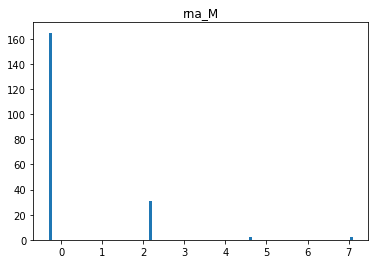

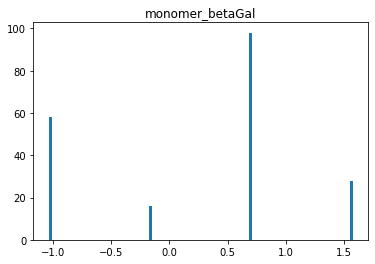

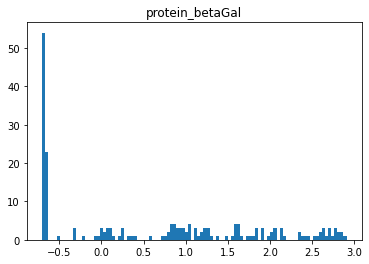

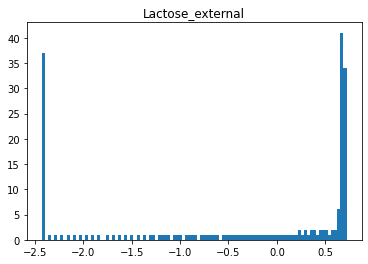

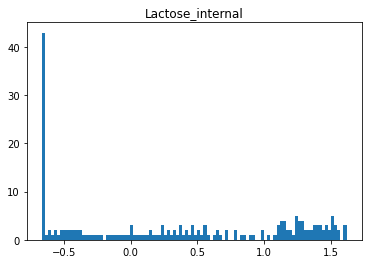

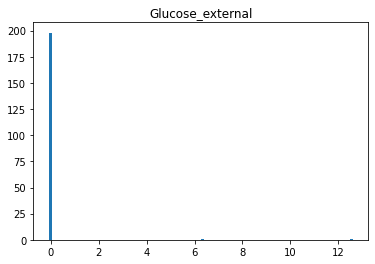

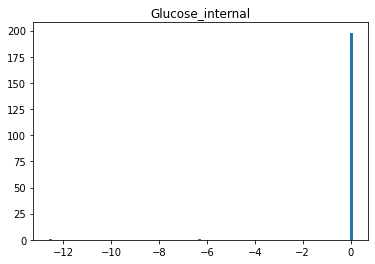

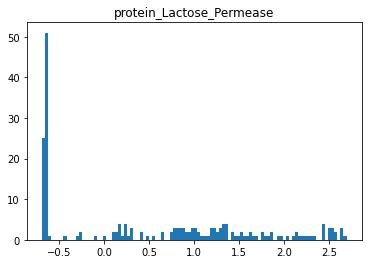

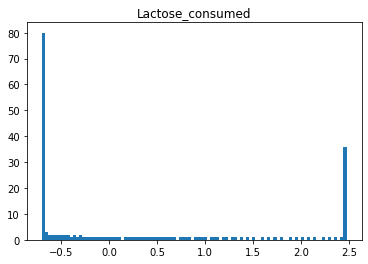

In [15]:
for col in train_data[0].columns:
    plt.hist(train_data[0].loc[:, col], bins = 100)
    plt.title(col)
    plt.show()

In [20]:
training_seq_lengths = tensor(np.array([len(train_data[i]) for i in range(len(train_data))]))
training_data_sequences = tensor(np.array([train_data[i].values for i in range(len(train_data))]))
test_seq_lengths = tensor(np.array([len(val_data[i]) for i in range(len(val_data))]))
test_data_sequences = tensor(np.array([val_data[i].values for i in range(len(val_data))]))
val_seq_lengths = tensor(np.array([len(test_data[i]) for i in range(len(test_data))]))
val_data_sequences = tensor(np.array([test_data[i].values for i in range(len(test_data))]))
N_train_data = len(training_seq_lengths)
N_train_time_slices = sum(training_seq_lengths)
N_mini_batches = int(N_train_data / 10 + int(N_train_data % 10 > 0))

In [21]:
N_mini_batches

8

Example data

In [49]:
def process_data(base_path, dataset, min_note=21, note_range=88):
    output = os.path.join(base_path, dataset.filename)
    if os.path.exists(output):
        try:
            with open(output, "rb") as f:
                return pickle.load(f)
        except (ValueError, UnicodeDecodeError):
            # Assume python env has changed.
            # Recreate pickle file in this env's format.
            os.remove(output)

    print("processing raw data - {} ...".format(dataset.name))
    data = pickle.load(urlopen(dataset.url))
    processed_dataset = {}
    for split, data_split in data.items():
        processed_dataset[split] = {}
        n_seqs = len(data_split)
        processed_dataset[split]["sequence_lengths"] = torch.zeros(
            n_seqs, dtype=torch.long
        )
        processed_dataset[split]["sequences"] = []
        for seq in range(n_seqs):
            seq_length = len(data_split[seq])
            processed_dataset[split]["sequence_lengths"][seq] = seq_length
            processed_sequence = torch.zeros((seq_length, note_range))
            for t in range(seq_length):
                note_slice = torch.tensor(list(data_split[seq][t])) - min_note
                slice_length = len(note_slice)
                if slice_length > 0:
                    processed_sequence[t, note_slice] = torch.ones(slice_length)
            processed_dataset[split]["sequences"].append(processed_sequence)
    pickle.dump(processed_dataset, open(output, "wb"), pickle.HIGHEST_PROTOCOL)
    print("dumped processed data to %s" % output)
# ingest training/validation/test data from disk
def load_data(dataset):
    # download and process dataset if it does not exist
    base_path = r"../data/"
    process_data(base_path, dataset)
    file_loc = os.path.join(base_path, dataset.filename)
    with open(file_loc, "rb") as f:
        dset = pickle.load(f)
        for k, v in dset.items():
            sequences = v["sequences"]
            dset[k]["sequences"] = pad_sequence(sequences, batch_first=True).type(
                torch.Tensor
            )
            dset[k]["sequence_lengths"] = v["sequence_lengths"].to(
                device=torch.Tensor().device
            )
    return dset

In [213]:
dset = namedtuple("dset", ["name", "url", "filename"])
JSB_CHORALES = dset(
    "jsb_chorales",
    "https://d2hg8soec8ck9v.cloudfront.net/datasets/polyphonic/jsb_chorales.pickle",
    "jsb_chorales.pkl",
)


In [215]:
data = load_data(JSB_CHORALES)

In [228]:
data['test']["sequences"][1][4]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

#### Training functions

In [50]:
def get_mini_batch(mini_batch_indices, sequences, seq_lengths, cuda=False):
    # get the sequence lengths of the mini-batch
    seq_lengths = seq_lengths[mini_batch_indices]
    # sort the sequence lengths
    _, sorted_seq_length_indices = torch.sort(seq_lengths)
    sorted_seq_length_indices = sorted_seq_length_indices.flip(0)
    sorted_seq_lengths = seq_lengths[sorted_seq_length_indices]
    sorted_mini_batch_indices = mini_batch_indices[sorted_seq_length_indices]

    # compute the length of the longest sequence in the mini-batch
    T_max = torch.max(seq_lengths)
    # this is the sorted mini-batch
    mini_batch = sequences[sorted_mini_batch_indices, 0:T_max, :]
    # this is the sorted mini-batch in reverse temporal order
    mini_batch_reversed = reverse_sequences(mini_batch, sorted_seq_lengths)
    # get mask for mini-batch
    mini_batch_mask = get_mini_batch_mask(mini_batch, sorted_seq_lengths)

    # cuda() here because need to cuda() before packing
    if cuda:
        mini_batch = mini_batch.cuda()
        mini_batch_mask = mini_batch_mask.cuda()
        mini_batch_reversed = mini_batch_reversed.cuda()

    # do sequence packing
    mini_batch_reversed = nn.utils.rnn.pack_padded_sequence(
        mini_batch_reversed, sorted_seq_lengths, batch_first=True
    )

    return mini_batch, mini_batch_reversed, mini_batch_mask, sorted_seq_lengths

In [51]:
def process_minibatch(epoch, which_mini_batch, shuffled_indices, mini_batch_size, annealing_epochs, minimum_annealing_factor):
    if annealing_epochs > 0 and epoch < annealing_epochs:
        # compute the KL annealing factor appropriate
        # for the current mini-batch in the current epoch
        min_af = minimum_annealing_factor
        annealing_factor = min_af + (1.0 - min_af) * \
            (float(which_mini_batch + epoch * N_mini_batches + 1) /
             float(annealing_epochs * N_mini_batches))
    else:
        # by default the KL annealing factor is unity
        annealing_factor = 1.0

    # compute which sequences in the training set we should grab
    mini_batch_start = (which_mini_batch * mini_batch_size)
    mini_batch_end = np.min([(which_mini_batch + 1) * mini_batch_size,
                             N_train_data])
    mini_batch_indices = shuffled_indices[mini_batch_start:mini_batch_end]
    # grab the fully prepped mini-batch using the helper function in the data loader
    mini_batch, mini_batch_reversed, mini_batch_mask, mini_batch_seq_lengths \
        = get_mini_batch(mini_batch_indices, training_data_sequences,
                              training_seq_lengths, cuda=False)
    mini_batch = mini_batch.float()
    mini_batch_reversed = mini_batch_reversed.float()
    mini_batch_mask = mini_batch_mask.float()
    #mini_batch_seq_lengths = mini_batch_seq_lengths.float()

    # do an actual gradient step
    loss = svi.step(mini_batch, mini_batch_reversed, mini_batch_mask,
                     mini_batch_seq_lengths, annealing_factor)
    # keep track of the training loss
    return loss

#### Test Model

Setup function to test model

In [52]:
# package repeated copies of val/test data for faster evaluation
# (i.e. set us up for vectorization)
n_eval_samples = 1
def rep(x):
    return np.repeat(x, n_eval_samples, axis=0)

# get the validation/test data ready for the dmm: pack into sequences, etc.
val_seq_lengths = rep(val_seq_lengths)
test_seq_lengths = rep(test_seq_lengths)
val_batch, val_batch_reversed, val_batch_mask, val_seq_lengths = get_mini_batch(
    np.arange(n_eval_samples * val_data_sequences.shape[0]), rep(val_data_sequences),
    val_seq_lengths, cuda=False)
val_batch = val_batch.float()
val_batch_reversed = val_batch_reversed.float()
val_batch_mask = val_batch_mask.float()

test_batch, test_batch_reversed, test_batch_mask, test_seq_lengths = \
    get_mini_batch(np.arange(n_eval_samples * test_data_sequences.shape[0]),
                        rep(test_data_sequences),
                        test_seq_lengths, cuda=False)
test_batch = test_batch.float()
test_batch_reversed = test_batch_reversed.float()
test_batch_mask = test_batch_mask.float()


In [53]:
sum(val_seq_lengths)

tensor(2000, dtype=torch.int32)

In [54]:
def do_evaluation():
    # put the RNN into evaluation mode (i.e. turn off drop-out if applicable)
    dmm.rnn.eval()

    # compute the validation and test loss
    val_nll = svi.evaluate_loss(val_batch, val_batch_reversed, val_batch_mask,
                                 val_seq_lengths) / sum(val_seq_lengths)
    test_nll = svi.evaluate_loss(test_batch, test_batch_reversed, test_batch_mask,
                                  test_seq_lengths) / sum(test_seq_lengths)

    # put the RNN back into training mode (i.e. turn on drop-out if applicable)
    dmm.rnn.train()
    return val_nll, test_nll

#### train model

In [55]:
num_epochs = 1500
val_test_frequency = 50

In [56]:
times = [time.time()]
val_nll_list = list()
for epoch in range(num_epochs):
    # accumulator for our estimate of the negative log likelihood
    # (or rather -elbo) for this epoch
    epoch_nll = 0.0
    # prepare mini-batch subsampling indices for this epoch
    shuffled_indices = np.arange(N_train_data)
    np.random.shuffle(shuffled_indices)

    # process each mini-batch; this is where we take gradient steps
    for which_mini_batch in range(N_mini_batches):
        epoch_nll += process_minibatch(epoch, which_mini_batch, shuffled_indices, 10, 100, .01)

    # report training diagnostics
    times.append(time.time())
    epoch_time = times[-1] - times[-2]
    print("[training epoch %04d]  %.4f \t\t\t\t(dt = %.3f sec)" %
        (epoch, epoch_nll / N_train_time_slices, epoch_time))
    
    # do evaluation on test and validation data and report results
    if val_test_frequency > 0 and epoch > 0 and epoch % val_test_frequency == 0:
        val_nll, test_nll = do_evaluation()
        val_nll_list.append(val_nll)
        print(
            "[val/test epoch %04d]  %.4f  %.4f" % (epoch, val_nll, test_nll)
        )

<ipython-input-33-99292c118c6e>:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_dist = dist.Normal(tensor(z_loc), tensor(z_scale))


[training epoch 0000]  15.8875 				(dt = 4.310 sec)
[training epoch 0001]  15.8979 				(dt = 4.249 sec)
[training epoch 0002]  15.9280 				(dt = 4.296 sec)
[training epoch 0003]  15.9738 				(dt = 4.138 sec)
[training epoch 0004]  16.0695 				(dt = 4.124 sec)
[training epoch 0005]  16.0518 				(dt = 4.149 sec)
[training epoch 0006]  16.0981 				(dt = 4.114 sec)
[training epoch 0007]  16.0981 				(dt = 4.180 sec)
[training epoch 0008]  16.1770 				(dt = 4.126 sec)
[training epoch 0009]  16.2353 				(dt = 4.113 sec)
[training epoch 0010]  16.2747 				(dt = 4.158 sec)
[training epoch 0011]  16.2704 				(dt = 4.331 sec)
[training epoch 0012]  16.3073 				(dt = 4.079 sec)
[training epoch 0013]  16.3764 				(dt = 4.159 sec)
[training epoch 0014]  16.4081 				(dt = 4.139 sec)
[training epoch 0015]  16.4800 				(dt = 4.127 sec)
[training epoch 0016]  16.5252 				(dt = 4.154 sec)
[training epoch 0017]  16.5696 				(dt = 4.068 sec)
[training epoch 0018]  16.5639 				(dt = 4.128 sec)
[training ep

KeyboardInterrupt: 